# Binary Classification Deep Learning Model for Credit Card Default Using Keras
### David Lowe
### December 5, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Credit Card Default dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

ANALYSIS: The baseline performance of the model achieved an average accuracy score of 81.11%. After tuning the hyperparameters, the best model processed the training dataset with an accuracy of 82.00%. Furthermore, the final model processed the test dataset with an accuracy of 81.41%, which was consistent with the result from model training.

CONCLUSION: For this dataset, the model built using Keras and TensorFlow achieved a satisfactory result and should be considered for future modeling activities.

Dataset Used: Default of Credit Card Clients Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Any deep-learning modeling project genrally can be broken down into about six major tasks:
0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Set the random seed number for reproducible results
seedNum = 888

In [3]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import keras as K
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

Using TensorFlow backend.


In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
verbose = True
tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 10

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_kernel_init = K.initializers.RandomNormal(seed=seedNum)
default_loss = 'binary_crossentropy'
default_optimizer = K.optimizers.Adam(learning_rate=0.001)
default_epochs = 500
default_batches = 128
default_metrics = ['accuracy']

Num GPUs Available:  0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0


In [5]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [6]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [7]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [8]:
dataset_path = 'https://raw.githubusercontent.com/daines-analytics/datasets-public/master/default-of-credit-card-clients/default-of-credit-card-clients.csv'
Xy_original = pd.read_csv(dataset_path, sep=',', header=0, index_col=0, verbose=True)

# Take a peek at the dataframe after the import
Xy_original.head(10)

Tokenization took: 92.00 ms
Type conversion took: 73.86 ms
Parser memory cleanup took: 0.01 ms


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
9,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0


In [9]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
DEFAULT      30000 non-null int64
dtypes: int64(24)
memory usage: 5.7 MB


In [10]:
Xy_original.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [11]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DEFAULT      0
dtype: int64
Total number of NaN in the dataframe:  0


## 1.b) Data Cleaning

In [12]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'DEFAULT': 'targetVar'})

# Convert columns from one data type to another
Xy_original['LIMIT_BAL'] = Xy_original['LIMIT_BAL'].astype('float')
Xy_original['SEX'] = Xy_original['SEX'].astype('category')
Xy_original['EDUCATION'] = Xy_original['EDUCATION'].astype('category')
Xy_original['MARRIAGE'] = Xy_original['MARRIAGE'].astype('category')
Xy_original['AGE'] = Xy_original['AGE'].astype('float')
Xy_original['BILL_AMT1'] = Xy_original['BILL_AMT1'].astype('float')
Xy_original['BILL_AMT2'] = Xy_original['BILL_AMT2'].astype('float')
Xy_original['BILL_AMT3'] = Xy_original['BILL_AMT3'].astype('float')
Xy_original['BILL_AMT4'] = Xy_original['BILL_AMT4'].astype('float')
Xy_original['BILL_AMT5'] = Xy_original['BILL_AMT5'].astype('float')
Xy_original['BILL_AMT6'] = Xy_original['BILL_AMT6'].astype('float')
Xy_original['PAY_AMT1'] = Xy_original['PAY_AMT1'].astype('float')
Xy_original['PAY_AMT2'] = Xy_original['PAY_AMT2'].astype('float')
Xy_original['PAY_AMT3'] = Xy_original['PAY_AMT3'].astype('float')
Xy_original['PAY_AMT4'] = Xy_original['PAY_AMT4'].astype('float')
Xy_original['PAY_AMT5'] = Xy_original['PAY_AMT5'].astype('float')
Xy_original['PAY_AMT6'] = Xy_original['PAY_AMT6'].astype('float')

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,targetVar
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24.0,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26.0,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34.0,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37.0,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57.0,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
6,50000.0,1,1,2,37.0,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
7,500000.0,1,1,2,29.0,0,0,0,0,0,...,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0
8,100000.0,2,2,2,23.0,0,-1,-1,0,0,...,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0
9,140000.0,2,3,1,28.0,0,0,2,0,0,...,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,0


In [13]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
LIMIT_BAL    30000 non-null float64
SEX          30000 non-null category
EDUCATION    30000 non-null category
MARRIAGE     30000 non-null category
AGE          30000 non-null float64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null float64
BILL_AMT2    30000 non-null float64
BILL_AMT3    30000 non-null float64
BILL_AMT4    30000 non-null float64
BILL_AMT5    30000 non-null float64
BILL_AMT6    30000 non-null float64
PAY_AMT1     30000 non-null float64
PAY_AMT2     30000 non-null float64
PAY_AMT3     30000 non-null float64
PAY_AMT4     30000 non-null float64
PAY_AMT5     30000 non-null float64
PAY_AMT6     30000 non-null float64
targetVar    30000 non-null int64
dtypes: category(3), float64(14), int6

In [14]:
Xy_original.describe()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,targetVar
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [15]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
targetVar    0
dtype: int64
Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [16]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [17]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (30000, 24) X_original.shape: (30000, 23) y_original.shape: (30000,)


In [18]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

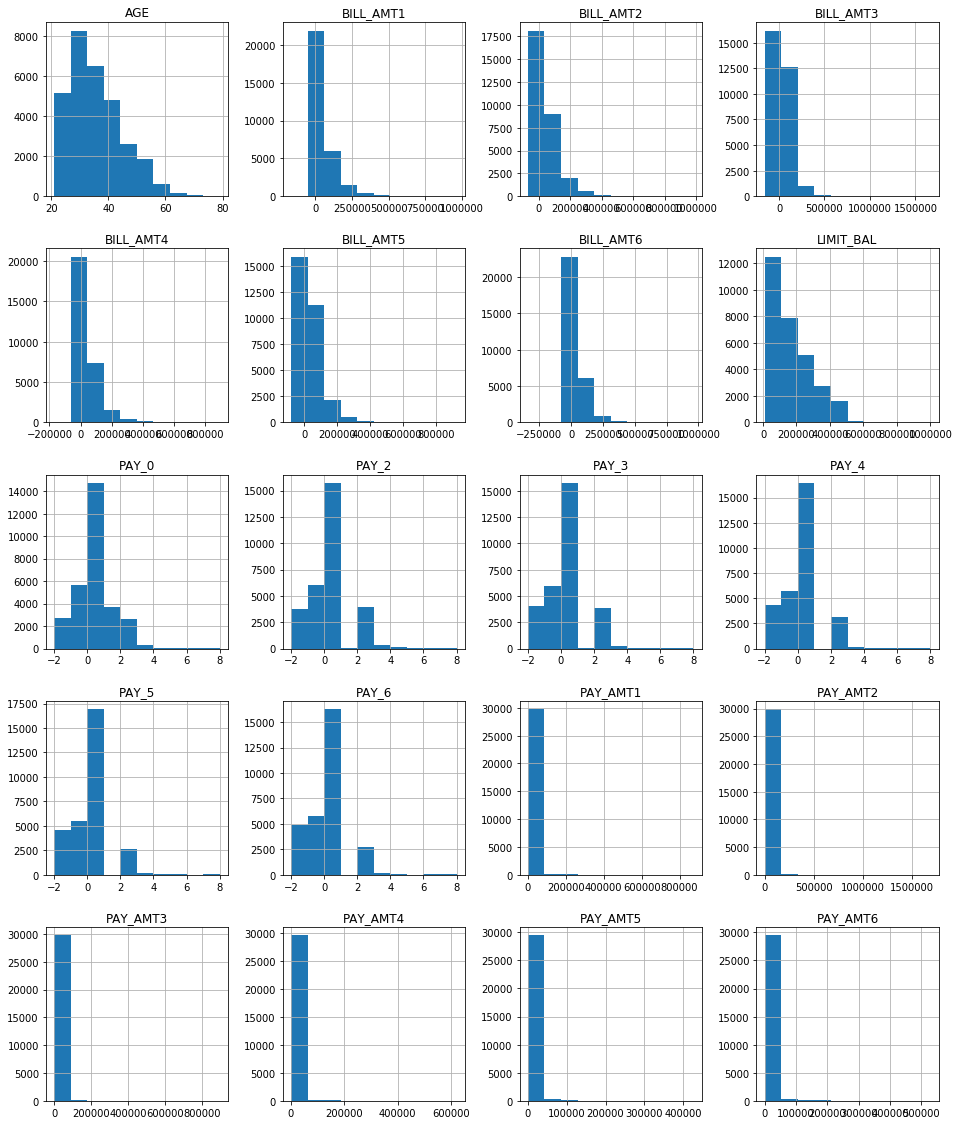

In [19]:
# Histograms for each attribute before pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [20]:
# Apply feature scaling techniques

# X_original = X_original.astype(float)
# preprocessing.scale(X_original, copy=False)
X_original['LIMIT_BAL'] = preprocessing.scale(X_original['LIMIT_BAL'])
X_original['AGE'] = preprocessing.scale(X_original['AGE'])
X_original['BILL_AMT1'] = preprocessing.scale(X_original['BILL_AMT1'])
X_original['BILL_AMT2'] = preprocessing.scale(X_original['BILL_AMT2'])
X_original['BILL_AMT3'] = preprocessing.scale(X_original['BILL_AMT3'])
X_original['BILL_AMT4'] = preprocessing.scale(X_original['BILL_AMT4'])
X_original['BILL_AMT5'] = preprocessing.scale(X_original['BILL_AMT5'])
X_original['BILL_AMT6'] = preprocessing.scale(X_original['BILL_AMT6'])
X_original['PAY_AMT1'] = preprocessing.scale(X_original['PAY_AMT1'])
X_original['PAY_AMT2'] = preprocessing.scale(X_original['PAY_AMT2'])
X_original['PAY_AMT3'] = preprocessing.scale(X_original['PAY_AMT3'])
X_original['PAY_AMT4'] = preprocessing.scale(X_original['PAY_AMT4'])
X_original['PAY_AMT5'] = preprocessing.scale(X_original['PAY_AMT5'])
X_original['PAY_AMT6'] = preprocessing.scale(X_original['PAY_AMT6'])

print(X_original.head(-10))

       LIMIT_BAL SEX EDUCATION MARRIAGE       AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
ID                                                                              
1      -1.136720   2         2        1 -1.246020      2      2     -1     -1   
2      -0.365981   2         2        2 -1.029047     -1      2      0      0   
3      -0.597202   2         2        2 -0.161156      0      0      0      0   
4      -0.905498   2         2        1  0.164303      0      0      0      0   
5      -0.905498   1         2        1  2.334029     -1      0     -1      0   
...          ...  ..       ...      ...       ...    ...    ...    ...    ...   
29986   0.558907   1         1        2 -0.595102     -2     -2     -2     -2   
29987   1.483795   1         1        2 -0.052670     -1     -1     -2     -2   
29988  -0.288907   1         1        2 -0.161156      0      0      0      0   
29989   0.635981   1         1        1 -0.161156      0      0      0      0   
29990  -0.134759   1        

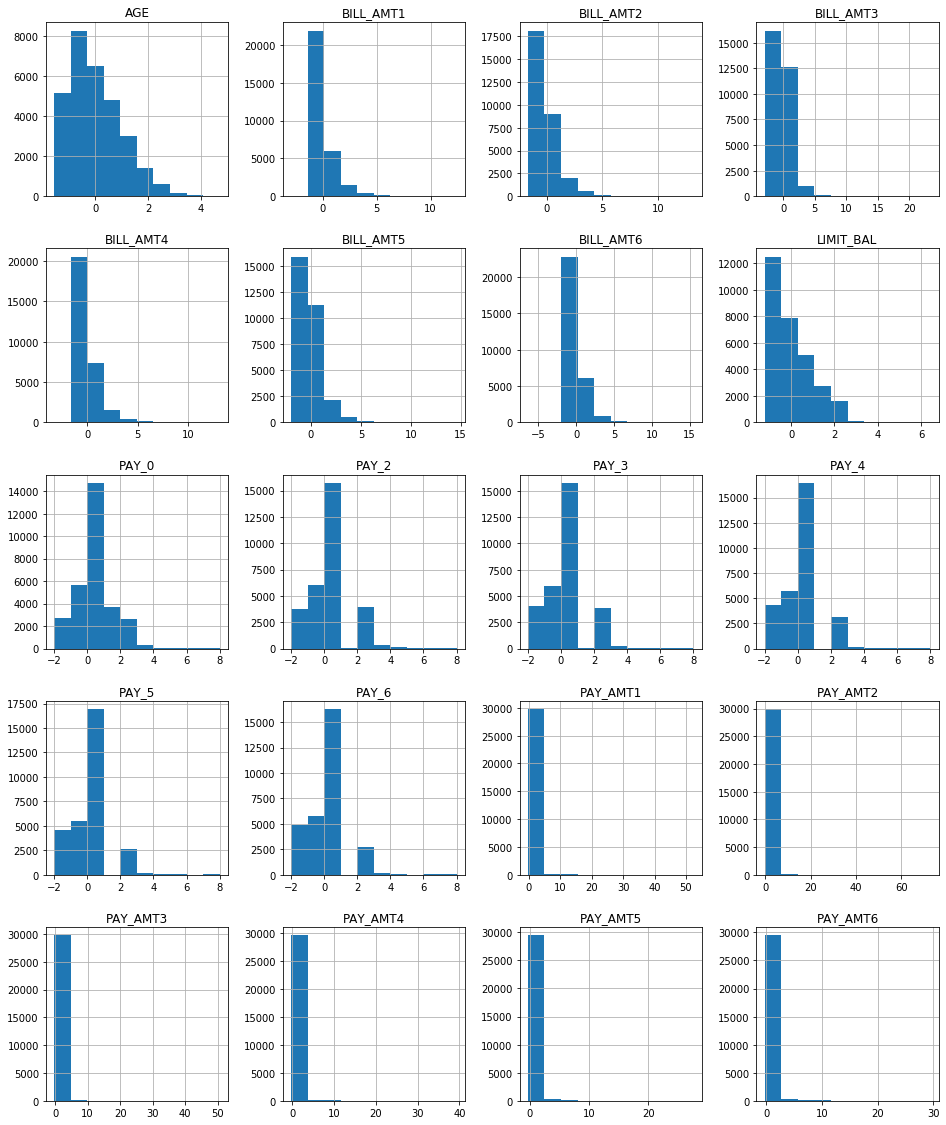

In [21]:
# Histograms for each attribute after pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [22]:
# Perform one-hot-encoding before splitting into trainig and test
X_original = pd.get_dummies(X_original)
print(X_original.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 33 columns):
LIMIT_BAL      30000 non-null float64
AGE            30000 non-null float64
PAY_0          30000 non-null int64
PAY_2          30000 non-null int64
PAY_3          30000 non-null int64
PAY_4          30000 non-null int64
PAY_5          30000 non-null int64
PAY_6          30000 non-null int64
BILL_AMT1      30000 non-null float64
BILL_AMT2      30000 non-null float64
BILL_AMT3      30000 non-null float64
BILL_AMT4      30000 non-null float64
BILL_AMT5      30000 non-null float64
BILL_AMT6      30000 non-null float64
PAY_AMT1       30000 non-null float64
PAY_AMT2       30000 non-null float64
PAY_AMT3       30000 non-null float64
PAY_AMT4       30000 non-null float64
PAY_AMT5       30000 non-null float64
PAY_AMT6       30000 non-null float64
SEX_1          30000 non-null uint8
SEX_2          30000 non-null uint8
EDUCATION_0    30000 non-null uint8
EDUCATION_1    30000 non-null uint8

## 1.d) Splitting Data into Training and Test Sets

In [23]:
# Encode class values as integers and perform one-hot-encoding
y_encoded = y_original.to_numpy()
# encoder = preprocessing.LabelEncoder()
# encoder.fit(y_original)
# y_encoded = encoder.transform(y_original)
print(y_encoded)

[1 1 0 ... 1 1 1]


In [24]:
# Split the data further into training and test datasets
X_encoded = X_original.to_numpy()
if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, 
                                                        stratify=y_encoded, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (22500, 33) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (22500,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (7500, 33) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (7500,) y_test.type: <class 'numpy.ndarray'>


In [25]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [26]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [27]:
# Define the Keras model required for KerasClassifier
def create_default_model():
    default_model = Sequential()
    default_model.add(Dense(66, input_shape=(33,), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, activation='sigmoid', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

In [28]:
# Initialize the Keras model
cv_model = KerasClassifier(build_fn=create_default_model, epochs=default_epochs, batch_size=default_batches, verbose=0)

In [29]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [30]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [31]:
startTimeModule = datetime.now()

# Fit and evaluate the Keras model using k-fold cross validation
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
results = cross_val_score(cv_model, X_train, y_train, cv=kfold)
print('Generating results using the metrics of', default_metrics)
print('All cross-Validate results:', results)
print('Baseline results [mean (std)]: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))

print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_keras_scratch_graph_810 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_keras_scratch_graph_399367 in device /job:localhost/replica:0/task:0/device:CPU:

In [32]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Optimize Model

In [33]:
if (notifyStatus): email_notify("Phase 4 Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [34]:
# Define the Keras model required for KerasClassifier
def create_customized_model(optimizer, kernel_init):
    customized_model = Sequential()
    customized_model.add(Dense(66, input_shape=(33,), activation='relu', kernel_initializer=kernel_init))
    customized_model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_init))
    customized_model.compile(loss=default_loss, optimizer=optimizer, metrics=default_metrics)
    return customized_model

In [35]:
startTimeModule = datetime.now()

# Create model
grid_model = KerasClassifier(build_fn=create_customized_model, verbose=0)

# Perform grid search using different epochs, batch sizes, and optimizers
optz_1 = K.optimizers.Adam(learning_rate=0.0010)
optz_2 = K.optimizers.Adam(learning_rate=0.0005)
optz_3 = K.optimizers.Adam(learning_rate=0.0002)
optimizer_grid = [optz_1, optz_2, optz_3]
init_1 = K.initializers.RandomNormal(seed=seedNum)
init_2 = K.initializers.Orthogonal(seed=seedNum)
init_grid = [init_1, init_2]
epoch_grid = [500]
batch_grid = [64, 128, 256]
param_grid = dict(optimizer=optimizer_grid, kernel_init=init_grid, epochs=epoch_grid, batch_size=batch_grid)
grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=n_folds, n_jobs=n_jobs, verbose=3)
# n_iter = int(len(optimizer_grid) * len(init_grid) * len(epoch_grid) * len(batch_grid) * 0.5)
# grid = RandomizedSearchCV(estimator=grid_model, param_distributions=param_grid, n_iter=n_iter, cv=n_folds, n_jobs=n_jobs, verbose=3)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 111.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 144.2min finished


Executing op __inference_keras_scratch_graph_3996010 in device /job:localhost/replica:0/task:0/device:CPU:0
Best: 0.820044 using {'batch_size': 256, 'epochs': 500, 'kernel_init': <keras.initializers.RandomNormal object at 0x7f404c331d50>, 'optimizer': <keras.optimizers.Adam object at 0x7f402c48e510>}
0.808711 (0.009837) with: {'batch_size': 64, 'epochs': 500, 'kernel_init': <keras.initializers.RandomNormal object at 0x7f404c331d50>, 'optimizer': <keras.optimizers.Adam object at 0x7f3f9863f850>}
0.817378 (0.005294) with: {'batch_size': 64, 'epochs': 500, 'kernel_init': <keras.initializers.RandomNormal object at 0x7f404c331d50>, 'optimizer': <keras.optimizers.Adam object at 0x7f402c48e650>}
0.817422 (0.008444) with: {'batch_size': 64, 'epochs': 500, 'kernel_init': <keras.initializers.RandomNormal object at 0x7f404c331d50>, 'optimizer': <keras.optimizers.Adam object at 0x7f402c48e510>}
0.803778 (0.008485) with: {'batch_size': 64, 'epochs': 500, 'kernel_init': <keras.initializers.Orthogona

In [36]:
best_optimizer = grid_result.best_params_["optimizer"]
best_kernel_init = grid_result.best_params_["kernel_init"]
best_epoch = grid_result.best_params_["epochs"]
best_batch = grid_result.best_params_["batch_size"]

In [37]:
if (notifyStatus): email_notify("Phase 4 Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [38]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [39]:
# Create the final model for evaluating the test dataset
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
final_model = create_customized_model(best_optimizer, best_kernel_init)
final_model.fit(X_train, y_train, epochs=best_epoch, batch_size=best_batch, verbose=0)

Forming the final model using: optimizer=<keras.optimizers.Adam object at 0x7f402c48e510>, kernel=<keras.initializers.RandomNormal object at 0x7f404c331d50>, epochs=500, batch_size=256
Executing op __inference_keras_scratch_graph_4217780 in device /job:localhost/replica:0/task:0/device:CPU:0


In [40]:
# Display a summary of the final model
print(final_model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 66)                2244      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 67        
Total params: 2,311
Trainable params: 2,311
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_12', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_23', 'trainable': True, 'batch_input_shape': (None, 33), 'dtype': 'float32', 'units': 66, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.05, 'seed': 892}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_24', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.05, 'seed': 892}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}]}


In [42]:
# Evaluate the Keras model on previously unseen data
scores = final_model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (final_model.metrics_names[1], scores[1]*100))
print("\n%s: %.2f" % (final_model.metrics_names[0], scores[0]))

Executing op __inference_keras_scratch_graph_4438837 in device /job:localhost/replica:0/task:0/device:CPU:0
7500/7500 [==============================] - 0s 40us/step

accuracy: 81.41%

loss: 0.44


In [43]:
# Make class predictions with the model
predictions = final_model.predict_classes(X_test)

# Summarize the first 20 cases
for i in range(20):
	print('Data item #%d predicted to be %d (expected %d)' % (i, predictions[i], y_test[i]))

Executing op __inference_keras_scratch_graph_4440032 in device /job:localhost/replica:0/task:0/device:CPU:0
Data item #0 predicted to be 0 (expected 0)
Data item #1 predicted to be 0 (expected 0)
Data item #2 predicted to be 0 (expected 0)
Data item #3 predicted to be 0 (expected 0)
Data item #4 predicted to be 0 (expected 1)
Data item #5 predicted to be 0 (expected 0)
Data item #6 predicted to be 1 (expected 1)
Data item #7 predicted to be 0 (expected 0)
Data item #8 predicted to be 0 (expected 0)
Data item #9 predicted to be 1 (expected 1)
Data item #10 predicted to be 0 (expected 0)
Data item #11 predicted to be 0 (expected 0)
Data item #12 predicted to be 0 (expected 1)
Data item #13 predicted to be 1 (expected 1)
Data item #14 predicted to be 0 (expected 0)
Data item #15 predicted to be 0 (expected 0)
Data item #16 predicted to be 0 (expected 0)
Data item #17 predicted to be 0 (expected 1)
Data item #18 predicted to be 0 (expected 0)
Data item #19 predicted to be 0 (expected 0)


In [44]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [45]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 3:17:29.355092
